<a href="https://colab.research.google.com/github/NabilOulbaz/Bertweet_finetuning/blob/main/DistilBERT_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets transformers
!pip install emoji==0.6.0
!apt install git-lfs
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 9.6 MB/s 
     |████████████████████████████████| 4.4 MB 57.3 MB/s 
     |████████████████████████████████| 140 kB 51.3 MB/s 
     |████████████████████████████████| 1.1 MB 32.1 MB/s 
     |████████████████████████████████| 212 kB 57.4 MB/s 
     |████████████████████████████████| 101 kB 6.8 MB/s 
     |████████████████████████████████| 596 kB 51.9 MB/s 
     |████████████████████████████████| 127 kB 61.1 MB/s 
     |████████████████████████████████| 6.6 MB 27.7 MB/s 
     |████████████████████████████████| 271 kB 63.8 MB/s 
     |████████████████████████████████| 94 kB 1.7 MB/s 
     |████████████████████████████████| 144 kB 26.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from transformers import Trainer, TrainingArguments
from pathlib import Path
from google.colab import drive
from datasets import load_dataset
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML
import torch
from transformers import  AutoModelForMaskedLM, AutoTokenizer 
from transformers import DataCollatorForLanguageModeling
import ktrain
from ktrain import text
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/M1 ATAL/Stage : EmotionAnalysis/datasets/cleaned"

/content/drive/MyDrive/M1 ATAL/Stage : EmotionAnalysis/datasets/cleaned


## Bertweet -> s19

### Importing Data

In [ ]:
s19_train = pd.read_csv('s19_train_balanced.csv')
s19_test = pd.read_csv('s19_test_balanced.csv')
s19_validation = pd.read_csv('s19_validation_balanced.csv')

In [ ]:
x_train = s19_train['dialogue'].tolist()
y_train = s19_train['emotion'].tolist()
x_test = s19_test['dialogue'].tolist()
y_test = s19_test['emotion'].tolist()
x_validation = s19_validation['dialogue'].tolist()
y_validation = s19_validation['emotion'].tolist()

In [ ]:
target = list(set(y_train))

In [ ]:
MODEL_NAME = "distilbert-base-uncased"

In [ ]:
t = text.Transformer(MODEL_NAME, maxlen=128, classes=target)


trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_validation, y_validation)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:490: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  "The class_names argument is replacing the classes argument. Please update your code."


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 14
	95percentile : 24
	99percentile : 34


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:738: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  "class_names argument was ignored, as they were extracted from string labels in dataset"


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 14
	95percentile : 24
	99percentile : 31


In [ ]:
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
2828/2828 [==============================] - 299s 101ms/step - loss: 1.0104 - accuracy: 0.5475
Epoch 2/2
2828/2828 [==============================] - 285s 101ms/step - loss: 1.6415 - accuracy: 0.2497


done.
Visually inspect loss plot and select learning rate associated with falling loss


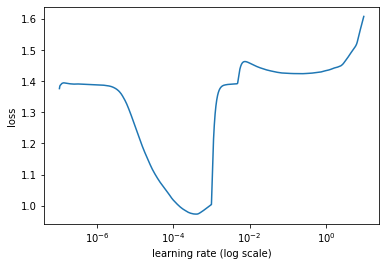

In [ ]:
# Finding the best learning rate
learner.lr_find(show_plot=True, max_epochs=2)

In [ ]:
learner.fit_onecycle(1e-4, 3)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/3
2829/2829 [==============================] - 309s 104ms/step - loss: 0.5171 - accuracy: 0.8121 - val_loss: 0.6707 - val_accuracy: 0.8060
Epoch 2/3
2829/2829 [==============================] - 293s 102ms/step - loss: 0.3971 - accuracy: 0.8659 - val_loss: 0.6089 - val_accuracy: 0.8020
Epoch 3/3
2829/2829 [==============================] - 292s 102ms/step - loss: 0.2255 - accuracy: 0.9239 - val_loss: 0.6069 - val_accuracy: 0.8360


In [ ]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

       anger       0.85      0.89      0.87       125
         joy       0.87      0.79      0.83       125
       other       0.74      0.84      0.79       125
     sadness       0.90      0.82      0.86       125

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



array([[111,   3,   8,   3],
       [  2,  99,  21,   3],
       [ 10,   5, 105,   5],
       [  7,   7,   8, 103]])

### Saving the model

In [ ]:
preproc = t

In [ ]:
%cd "/content/drive/MyDrive/M1 ATAL/Stage : EmotionAnalysis/Experiences"

/content/drive/MyDrive/M1 ATAL/Stage : EmotionAnalysis/Experiences


In [ ]:
predictor = ktrain.get_predictor(learner.model,preproc)
predictor.save('tgt-s19-balanced')  

### Importing saved src-s18-s18 model

In [ ]:
# Load the model for later
import pickle
from tensorflow.keras.models import load_model
features = pickle.load(open('/content/drive/MyDrive/M1 ATAL/Stage : EmotionAnalysis/Experiences/tgt-s19-balanced/tf_model.preproc','rb'))


In [ ]:
new_model = features.get_classifier()
new_model.load_weights('/content/drive/MyDrive/M1 ATAL/Stage : EmotionAnalysis/Experiences/tgt-s19-balanced/tf_model.h5')

### Testing on s18 test set

In [ ]:
%cd "/content/drive/MyDrive/M1 ATAL/Stage : EmotionAnalysis/datasets/cleaned"

/content/drive/MyDrive/M1 ATAL/Stage : EmotionAnalysis/datasets/cleaned


In [ ]:
predictor = ktrain.get_predictor(new_model,features)

In [ ]:
s18_test = pd.read_csv('s18_test_balanced.csv')
s18_val = pd.read_csv('s18_validation_balanced.csv')

In [ ]:
x_test = [*s18_test['Tweet'].tolist(),*s18_val['Tweet'].tolist()]
y_test = [*s18_test['emotion'].tolist(),*s18_val['emotion'].tolist()]

In [ ]:
y_hat = predictor.predict(x_test)

In [ ]:
conf_mat = confusion_matrix(y_test,y_hat,labels=['sadness', 'other', 'anger', 'joy'])

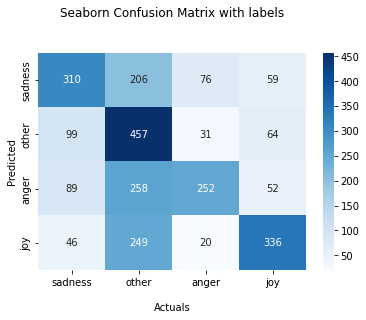

In [ ]:
ax = sns.heatmap(conf_mat, annot=True, cmap='Blues',fmt='0000')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActuals')
ax.set_ylabel('Predicted')

ax.xaxis.set_ticklabels(['sadness', 'other', 'anger', 'joy'])
ax.yaxis.set_ticklabels(['sadness', 'other', 'anger', 'joy'])
plt.show()


In [ ]:
print(metrics.classification_report(y_test, y_hat, target_names=['anger', 'joy', 'other', 'sadness']))

              precision    recall  f1-score   support

       anger       0.66      0.39      0.49       651
         joy       0.66      0.52      0.58       651
       other       0.39      0.70      0.50       651
     sadness       0.57      0.48      0.52       651

    accuracy                           0.52      2604
   macro avg       0.57      0.52      0.52      2604
weighted avg       0.57      0.52      0.52      2604



### Testing on s19 test set

In [ ]:
%cd "/content/drive/MyDrive/M1 ATAL/Stage : EmotionAnalysis/datasets/cleaned"

/content/drive/MyDrive/M1 ATAL/Stage : EmotionAnalysis/datasets/cleaned


In [ ]:
s19_test = pd.read_csv('s19_test_balanced.csv')
s19_val = pd.read_csv('s19_validation_balanced.csv')

In [ ]:
x_test = [*s19_test['dialogue'].tolist(),*s19_val['dialogue'].tolist()]
y_test = [*s19_test['emotion'].tolist(),*s19_val['emotion'].tolist()]

In [ ]:
y_hat = predictor.predict(x_test)

In [ ]:
print(metrics.classification_report(y_test, y_hat, target_names=['anger', 'joy', 'other', 'sadness']))

              precision    recall  f1-score   support

       anger       0.85      0.90      0.87       375
         joy       0.85      0.80      0.83       375
       other       0.77      0.84      0.80       375
     sadness       0.89      0.81      0.85       375

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500



### Testing on dd test set

In [ ]:
dd_test = pd.read_csv('dd_test_balanced.csv')
dd_val = pd.read_csv('dd_validation_balanced.csv')

In [ ]:
x_test = [*dd_test['dialogue'].tolist(),*dd_val['dialogue'].tolist()]
y_test = [*dd_test['emotion'].tolist(),*dd_val['emotion'].tolist()]

In [ ]:
y_hat = predictor.predict(x_test)

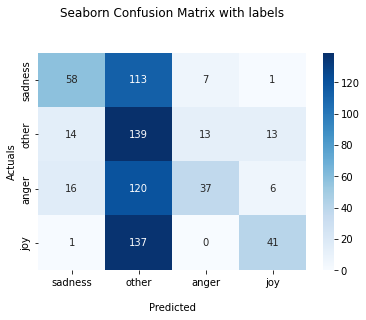

In [ ]:
conf_mat = confusion_matrix(y_test,y_hat,labels=['sadness', 'other', 'anger', 'joy'])

ax = sns.heatmap(conf_mat, annot=True, cmap='Blues',fmt='0000')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actuals')

ax.xaxis.set_ticklabels(['sadness', 'other', 'anger', 'joy'])
ax.yaxis.set_ticklabels(['sadness', 'other', 'anger', 'joy'])
plt.show()

In [ ]:
print(metrics.classification_report(y_test, y_hat, target_names=['anger', 'joy', 'other', 'sadness']))

              precision    recall  f1-score   support

       anger       0.65      0.21      0.31       179
         joy       0.67      0.23      0.34       179
       other       0.27      0.78      0.40       179
     sadness       0.65      0.32      0.43       179

    accuracy                           0.38       716
   macro avg       0.56      0.38      0.37       716
weighted avg       0.56      0.38      0.37       716

